In [26]:
import torch
import numpy as np
from neural_net import AgentNN
from neural_net_BC import BehaviorCloningModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder

## Define Hyperparameters

In [41]:
LR = 5e-4
N_EPOCHS = 20
BATCH_SIZE = 128
TEST_SIZE = 0.2

## Load and create dataset

In [28]:
Data = {
    'jump': [f for f in os.listdir("../expert_data/jump/")],
    'roll': [f for f in os.listdir("../expert_data/roll/")],
    'left': [f for f in os.listdir("../expert_data/left/")],
    'right': [f for f in os.listdir("../expert_data/right/")],
    'no_op': [f for f in os.listdir("../expert_data/no_op/")]
}

data_correct = {
    "observations": [sample for action, samples in Data.items() for sample in samples],
    "labels": [action for action, samples in Data.items() for sample in samples]
    }

data = pd.DataFrame(data_correct)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79678 entries, 0 to 79677
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   observations    79678 non-null  object
 1   labels          79678 non-null  object
 2   encoded_labels  79678 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [30]:
data.head(9000)

,observations,labels,encoded_labels
0,obs_729.npy,jump,0
1,obs_639.npy,jump,0
2,obs_3352.npy,jump,0
3,obs_2974.npy,jump,0
4,obs_3100.npy,jump,0
...,...,...,...
8995,obs_7069.npy,left,1
8996,obs_7194.npy,left,1
8997,obs_7243.npy,left,1
8998,obs_1278.npy,left,1


In [31]:
tr, val = train_test_split(data.labels, test_size=TEST_SIZE)
# tr = data.labels

In [32]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(list(tr.index))
# valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(list(val.index))

In [33]:
# print(len(list(tr.index)))

In [34]:
class SubwaySurfers_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_data, data_path):
        self.data_path = data_path
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_stack_name = os.path.join(self.data_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'observations'])
        image = np.load(img_stack_name)
        image = torch.tensor(image, dtype=torch.float32)

        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        return image, label

In [35]:
dataset = SubwaySurfers_Dataset(data, "/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/")

In [36]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

## Create a model

In [37]:
agent = AgentNN((4, 84, 84), 5)
# agent.load_state_dict(torch.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/models/12-06-2025-15_48_48/model_700.pt"))
model = BehaviorCloningModel(agent)

In [38]:
print(model)

BehaviorCloningModel(
  (agent_nn): AgentNN(
    (conv_layers): Sequential(
      (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
    )
    (network): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
      )
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=3136, out_features=256, bias=True)
      (3): ReLU()
    )
    (actor): Linear(in_features=256, out_features=5, bias=True)
    (critic): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Define loss function and optimizer

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Train the network

In [42]:
for epoch in range(1, N_EPOCHS+1):
    running_loss = 0.0
    correct = 0
    total_step = len(train_loader)

    print(f'Epoch {epoch}\n')
    
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(agent.device), target_.to(agent.device) # on GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward, backward, optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, N_EPOCHS, batch_idx, total_step, loss.item()))

Epoch 1

Epoch [1/20], Step [0/498], Loss: 0.4011
Epoch [1/20], Step [20/498], Loss: 0.5568
Epoch [1/20], Step [40/498], Loss: 0.6134
Epoch [1/20], Step [60/498], Loss: 0.4309
Epoch [1/20], Step [80/498], Loss: 0.3390
Epoch [1/20], Step [100/498], Loss: 0.5302
Epoch [1/20], Step [120/498], Loss: 0.4405
Epoch [1/20], Step [140/498], Loss: 0.5077
Epoch [1/20], Step [160/498], Loss: 0.4522
Epoch [1/20], Step [180/498], Loss: 0.3670
Epoch [1/20], Step [200/498], Loss: 0.4883
Epoch [1/20], Step [220/498], Loss: 0.6311
Epoch [1/20], Step [240/498], Loss: 0.4863
Epoch [1/20], Step [260/498], Loss: 0.4092
Epoch [1/20], Step [280/498], Loss: 0.5864
Epoch [1/20], Step [300/498], Loss: 0.5104
Epoch [1/20], Step [320/498], Loss: 0.5755
Epoch [1/20], Step [340/498], Loss: 0.3690
Epoch [1/20], Step [360/498], Loss: 0.4108
Epoch [1/20], Step [380/498], Loss: 0.3802
Epoch [1/20], Step [400/498], Loss: 0.5108
Epoch [1/20], Step [420/498], Loss: 0.3856
Epoch [1/20], Step [440/498], Loss: 0.4554
Epoch [1

In [19]:
# model.load_state_dict(torch.load("./classification_model_0.pt"))

In [20]:
X_test = data["labels"] + "/" + data["observations"]
y_test = data["encoded_labels"]

In [21]:
y_pred = [np.argmax(model.forward(torch.tensor(np.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/" + img), dtype=torch.float32).to(agent.device).unsqueeze(0)).cpu().detach().numpy()) for img in X_test]

In [ ]:
test_img = torch.tensor(np.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/roll/obs_0.npy"), dtype=torch.float32).to(agent.device)
test_img = test_img.unsqueeze(0)

print(model.forward(test_img))
print(np.argmax(model.forward(test_img).cpu().detach().numpy()))

AttributeError: 'BehaviorCloningModel' object has no attribute 'device'

In [22]:
def evaluate(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        metrics = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

        # print metrics
        print("Model Evaluation Metrics:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")

        # display confusion matrix heatmap
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(3, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

In [43]:
torch.save(model.agent_nn.state_dict(), "./classification_model_0.pt")

Model Evaluation Metrics:
Accuracy: 0.9597
Precision: 0.9594
Recall: 0.9597
F1-Score: 0.9594


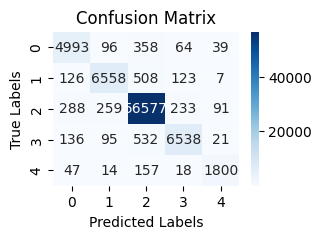

In [24]:
evaluate(y_test, y_pred)